In [1]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd
import re
from warnings import warn

In [2]:
import parsing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from task1 import get_slice_set, read_slice_with_annotations
from torch.utils.data import Dataset, DataLoader

### Note: this notebook uses pytorch-style Dataset and pytorch-original DataLoader classes

Dataset embeds the table of filenames of paired slices and a method to read them for each slice (table row).

DataLoader takes care of loading, batching, and asynchronous file reading.

In [5]:
class HeartDataset(Dataset):
    """An class representing a heart MRI dataset.
    """
    def __init__(self, filenames):
        self.filenames = filenames
        
    def __getitem__(self, index):
        slicedict = self.filenames.iloc[index]
        sample = read_slice_with_annotations(slicedict)
        return sample

    def __len__(self):
        return len(self.filenames)

    def __add__(self, other):
        return HeartDataset(pd.concat[self.filenames, other.filenames])

In [6]:
def np_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""

    error_msg = "batch must contain arrays, numbers, dicts or lists; found {}"
    elem_type = type(batch[0])
    
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch, axis=0)
    
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if re.search('[SaUO]', elem.dtype.str) is not None:
                raise TypeError(error_msg.format(elem.dtype))
            return np.stack(batch, 0)
        if elem.shape == ():  # scalars
            py_type = float if elem.dtype.name.startswith('float') else int
            return (list(map(py_type, batch)))
    elif isinstance(batch[0], int):
        return np.stack(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], str):
        return batch
    elif isinstance(batch[0], dict):
        return {key: np_collate([d[key] for d in batch]) for key in batch[0]}
    elif isinstance(batch[0], (list, tuple)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    raise TypeError((error_msg.format(type(batch[0]))))

In [7]:
def np_collate_dict_to_tuple(batch):
    """collates a batch of dictionaries with keys: ('image', 'imask') 
    to a tuple of arrays (image, imask)"""
    results = [np_collate([d[key] for d in batch]) for key in ['image', 'imask']]
    return tuple(results)# results['image'], results['imask']

In [8]:
dir_data = 'final_data'
fn_link = f'{dir_data}/link.csv'

metadata = pd.read_csv(fn_link)
print( f'{metadata.shape[0]} series parsed')

filenames = get_slice_set(metadata, dir_data)
print( f'{filenames.shape[0]} files parsed')

5 series parsed
96 files parsed


In [9]:
hdset = HeartDataset(filenames)

In [10]:
hdloader = DataLoader(hdset, batch_size=8, shuffle=True, collate_fn=np_collate_dict_to_tuple)

## Run one batch loader iteration

In [11]:
for x in hdloader:
    break

## Visualize an image and its mask for one slide

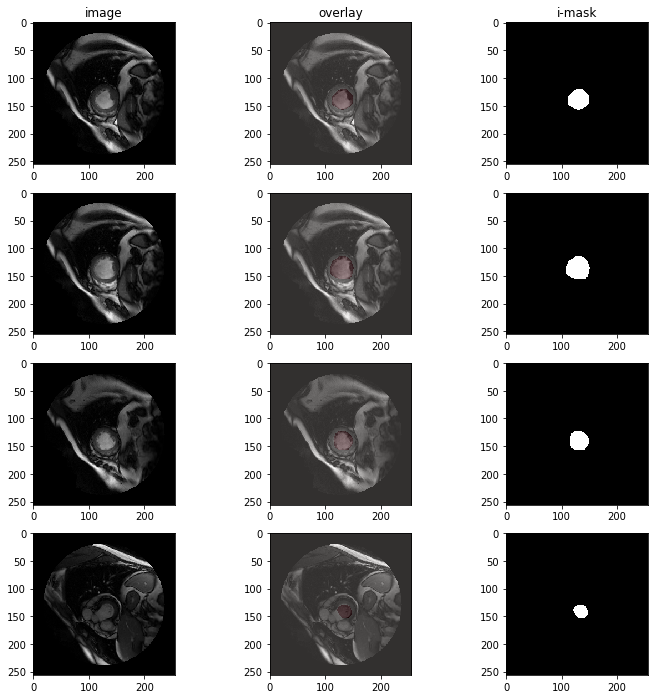

In [82]:
num_samples = 4
fig, axs = plt.subplots(num_samples, 3, figsize = (12,12))
for sample_num in range(num_samples):
    axs[sample_num][0].imshow(x[0][sample_num], cmap='gray')
    axs[sample_num][2].imshow(x[1][sample_num], cmap='gray')

    axs[sample_num][1].imshow(x[0][sample_num], cmap='gray')
    axs[sample_num][1].imshow(x[1][sample_num], cmap='Reds', alpha=0.2, vmin=0, vmax=1)

axs[0][0].set_title('image')
axs[0][1].set_title('overlay')
axs[0][2].set_title('i-mask')
plt.savefig('task2.png')
pass

### Make sure shuffling works

In [79]:
num_reps = 3
shuffle = False

first_batches = []
for rep in range(num_reps):
    hdloader = DataLoader(hdset, batch_size=8, shuffle=shuffle, collate_fn=np_collate_dict_to_tuple)
    for x in hdloader:
        break
    first_batches.append(x[0])

In [80]:
imask_sum_first_batch = [tuple(x.sum(-1).sum(-1)) for x in first_batches]

In [81]:
assert (len(set(imask_sum_first_batch)) == num_reps) == shuffle